In [1]:
#Importation of all the libraries
import geopandas as gpd
import statistics as st
import matplotlib.pyplot as plt
import csv
import numpy as np
from scipy.stats import linregress
import zlib
from os import listdir
import pandas as pd
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [2]:
#Loading of the data from E-Redes
electricity = pd.read_csv('data/energy.csv', sep=';')

In [3]:
#Creating a list of all the zip codes
zipcode = list(set(list(electricity['Zip Code'])))
zipcode.sort()

In [4]:
#Creatin a variable to collect the yearly electricity consumption
electricity_consumption = {}

for i in zipcode:
    
    #Making sure we have the 12 months of data
    if electricity[electricity['Zip Code']==i].shape[0] == 12:
        
        #Summing all the months
        electricity_consumption[i] = int(electricity[electricity['Zip Code']==i]['Active Energy (kWh)'].sum())

In [5]:
#Creation of the list to link zipcode and freguesia
freguesia = {}

freguesia[1000] = 'Areeiro'
freguesia[1050] = 'Avenidas Novas'
freguesia[1070] = 'Campolide'
freguesia[1100] = 'Santa Maria Maior'
freguesia[1150] = 'Arroios'
freguesia[1170] = 'Penha de França'
freguesia[1200] = 'Misericórdia'
freguesia[1250] = 'Santo António'
freguesia[1300] = 'Alcântara'
freguesia[1350] = 'Campo de Ourique'
freguesia[1400] = 'Belém'
freguesia[1500] = 'Benfica' 
freguesia[1600] = 'Lumiar'
freguesia[1700] = 'Alvalade'
freguesia[1750] = 'Santa Clara'
freguesia[1800] = 'Olivais'
freguesia[1900] = 'Beato'
freguesia[1950] = 'Marvila'
freguesia[1990] = 'Parque das Nações'

freguesia = {value:key for key, value in freguesia.items()}

In [6]:
freguesia['Ajuda'] = 1300
freguesia['São Domingos de Benfica'] = 1500
freguesia['Carnide'] = 1600
freguesia['Estrela'] = 1200
freguesia['São Vicente'] = 1100

In [7]:
#Importation of the population data per freguesia (INE: https://censos.ine.pt/xportal/xmain?xpid=CENSOS&xpgid=censos_quadros)
population = pd.read_csv('data/population.csv', sep=';')

In [8]:
#Simplification of the dataframe
population.drop(['S7A2021:2021-T:MF-1:0 - 14 years',
       'S7A2021:2021-T:MF-2:15 - 24 years',
       'S7A2021:2021-T:MF-3:25 - 64 years',
       'S7A2021:2021-T:MF-4:65 and more years', 'S7A2021:2021-1:M-T:Total',
       'S7A2021:2021-1:M-1:0 - 14 years', 'S7A2021:2021-1:M-2:15 - 24 years',
       'S7A2021:2021-1:M-3:25 - 64 years',
       'S7A2021:2021-1:M-4:65 and more years', 'S7A2021:2021-2:F-T:Total',
       'S7A2021:2021-2:F-1:0 - 14 years', 'S7A2021:2021-2:F-2:15 - 24 years',
       'S7A2021:2021-2:F-3:25 - 64 years',
       'S7A2021:2021-2:F-4:65 and more years'], axis=1, inplace=True)

population.drop([0,1,2,3,4], axis=0, inplace=True)

population.columns = ['freguesia', 'hab']

population.reset_index(inplace=True, drop=True)

l=[]
for i in list(population.freguesia):
    l.append(i[7:])

population.freguesia = l

In [9]:
#Adding the zipcode column 
population['zipcode'] = population.apply(lambda x: freguesia[x.freguesia] if x.freguesia in freguesia else 0, axis=1)

In [10]:
#Adding the electricity
population['electricity (kWh)'] = population.apply(lambda x: electricity_consumption[x.zipcode] if x.zipcode in electricity_consumption else 0, axis=1)

In [11]:
#Calculating the waste by the per capita approach
#Coefficient factors from observatorio lisboa
population['waste total (kg)']  = population.apply(lambda x: x.hab*597, axis=1)
population['waste indiferenciada (kg)']  = population.apply(lambda x: x.hab*597*0.754, axis=1)
population['waste selectiva (kg)']  = population.apply(lambda x: x.hab*597*(1-0.754), axis=1)

In [12]:
#Loading of the geogrphical data
geo = gpd.read_file('data/Lisboa_Freguesias_CAOP2015_TM06.shp', )

In [13]:
#Sorting the dataframe
geo['Freguesia'] = geo.apply(lambda x: 'São Domingos de Benfica' if x.Freguesia == 'S1o Domingos de Benfica' else x.Freguesia, axis=1)
geo['Freguesia'] = geo.apply(lambda x: 'São Vicente' if x.Freguesia == 'S1o Vicente' else x.Freguesia, axis=1)

geo = geo.sort_values(by = 'Freguesia').copy(deep=True)
geo.reset_index(inplace=True, drop=True)

In [14]:
#Setting now the new geometry
population['geometry'] = geo.geometry

<AxesSubplot:>

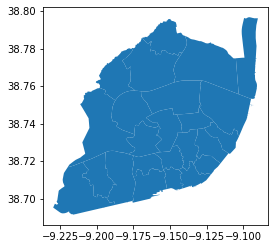

In [15]:
#Creation of the final GeoDataFrame
gdf = gpd.GeoDataFrame(population, geometry = population.geometry).set_crs('epsg:3763')
gdf = gdf.to_crs('epsg:4326')

gdf.plot()

In [16]:
#Creating a dictionnary with the total inhabitant per zipcode (some zip codes cover two freguesia)
df2 = gdf.groupby('zipcode').sum()

dic= {}
for i in df2.index:
    dic[i] = int(df2[df2.index==i].hab)
    
gdf['hab_per_zc'] = gdf.apply(lambda x: dic[x.zipcode], axis=1)

In [17]:
#Calculating total electricity and then electricity/hab
gdf['electricity_freg (kWh)'] = gdf.apply(lambda x: int(x['electricity (kWh)']*x.hab/x.hab_per_zc), axis=1)
gdf['electricty_per_hab (kWh)'] = gdf['electricity_freg (kWh)']/gdf['hab']

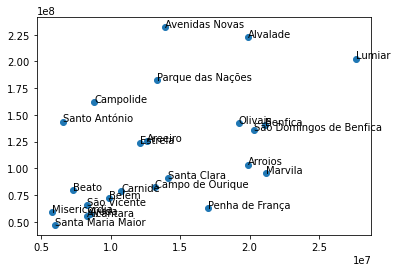

In [18]:
#Graphic representation
x = gdf['waste total (kg)']
y = gdf['electricity_freg (kWh)']
n = gdf['freguesia']

fig, ax = plt.subplots()
ax.scatter(x, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (x[i], y[i]))

In [19]:
#Factor emission electricty: 0.257 kg C02eq / kWh, 69% (APA - Factor da emissao da electricidade)
#Factor emission  gaz: 0.205 kg CO2eq / kWh, 31% (GALP: https://www.galp.com/pt/pt/empresas/eletricidade-e-gas/Apoio-ao-Cliente/Centro-de-Informacao/Eletricidade-e-Gas-Natural-da-Galp)

FE_E = 0.257
FE_G = 0.205

gdf['CO2_from_energy (kt CO2eq)'] = gdf['electricity_freg (kWh)']*(FE_E + FE_G*0.316/(1-0.316))/1000000

a =  0.0009963996780126122  b =  17.849451708252495  r^2 =  0.2671416049345366


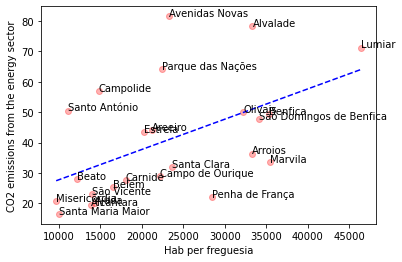

In [20]:
#Linear regression
x = gdf['hab']
y = gdf['CO2_from_energy (kt CO2eq)']
n = gdf['freguesia']
a,b,r,p,std_err = linregress(x,y)

plt.plot(x,y,'ro', alpha=0.3)
mi,ma = min(x), max(x)
plt.plot([mi, ma], [a*mi+b, a*ma+b], 'b--')
plt.xlabel('Hab per freguesia')
plt.ylabel('CO2 emissions from the energy sector')

for i, txt in enumerate(n):
    plt.annotate(txt, (x[i], y[i]))
    
print('a = ', a, ' b = ', b, ' r^2 = ', r**2)

In [21]:
#Factor emission waste and wastewater: 0.000169 ktC02 eq/hab
#508686 hab in observatorios for 86kt CO2eq

emissions_from_waste = 86

gdf['CO2_from_waste (kt CO2eq)'] = gdf['hab']*emissions_from_waste/gdf['hab'].sum()
gdf['CO2_from_waste_per_hab'] = gdf['CO2_from_waste (kt CO2eq)']/gdf['hab']

In [22]:
#The 2019 data is 725kt CO2eq for the scope 2.
gdf['CO2_from_energy (kt CO2eq)'].sum()/725*100

134.0990068494664

In [23]:
#Adding two columns
gdf['CO2_from_energy_per_hab (tCO2eq)'] = gdf['CO2_from_energy (kt CO2eq)']/gdf['hab']*1000
gdf['electricity (kWh)'].sum()/1000000

3730.44555

In [24]:
#Estate price per freguesia according to:
#https://www.globalcitizensolutions.com/buy-property-lisbon/#:~:text=Cheaper%20areas%20of%20Lisbon%20include,and%20usually%20bigger%20as%20well.

estateprice = {}

estateprice['Areeiro'] = 4766
estateprice['Avenidas Novas'] = 6145
estateprice['Campolide'] = 6145
estateprice['Santa Maria Maior'] = 6145
estateprice['Arroios'] = 4766
estateprice['Penha de França'] = 4225
estateprice['Misericórdia'] = 7060
estateprice['Santo António'] = 7060
estateprice['Alcântara'] = 6145
estateprice['Campo de Ourique'] = 6145
estateprice['Belém'] = 6145
estateprice['Benfica'] = 3412
estateprice['Lumiar'] = 4225
estateprice['Alvalade'] = 6145
estateprice['Santa Clara'] = 2529
estateprice['Olivais'] = 3412
estateprice['Beato'] = 3412
estateprice['Marvila'] = 4225
estateprice['Parque das Nações'] = 6145
estateprice['Ajuda'] = 4225
estateprice['São Domingos de Benfica'] = 4225
estateprice['Carnide'] = 4225
estateprice['Estrela'] = 6145
estateprice['São Vicente'] = 4766

In [25]:
#Adding the real estate price
gdf['Estate price (€/m²)'] = gdf.apply(lambda x: estateprice[x.freguesia], axis=1)

In [26]:
gdf['estate_weight'] = gdf['Estate price (€/m²)']/gdf['Estate price (€/m²)'].median()

In [27]:
#Importing the API of Joao Carabetta from https://github.com/JoaoCarabetta/osmpy
import osmpy

#We simplify the Polygon to win some time and solve some problems of Polygons beeing too long
l= [] 
for i in range(len(gdf.geometry)):
    
    print('Traitement de :', i, ' - ', gdf.freguesia[i])
    l.append(osmpy.get('RoadLength', gdf.geometry[i].simplify(0.0001)))

Traitement de : 0  -  Ajuda
Traitement de : 1  -  Alcântara
Traitement de : 2  -  Alvalade
Traitement de : 3  -  Areeiro
Traitement de : 4  -  Arroios
Traitement de : 5  -  Avenidas Novas
Traitement de : 6  -  Beato
Traitement de : 7  -  Belém
Traitement de : 8  -  Benfica
Traitement de : 9  -  Campo de Ourique
Traitement de : 10  -  Campolide
Traitement de : 11  -  Carnide
Traitement de : 12  -  Estrela
Traitement de : 13  -  Lumiar
Traitement de : 14  -  Marvila
Traitement de : 15  -  Misericórdia
Traitement de : 16  -  Olivais
Traitement de : 17  -  Parque das Nações
Traitement de : 18  -  Penha de França
Traitement de : 19  -  Santa Clara
Traitement de : 20  -  Santa Maria Maior
Traitement de : 21  -  Santo António
Traitement de : 22  -  São Domingos de Benfica
Traitement de : 23  -  São Vicente


In [28]:
#Differece between the normal geometry and the simplify is less than 0.07%
100-gdf.geometry[19].simplify(0.0001).area/gdf.geometry[19].area*100

0.06704960962150608

In [29]:
#All different road types
road_type = {'motorway' : 13.50,
             'motorway_link' : 13.50,
             'trunk' : 13.50,
             'trunk_link' : 13.50,
             'primary' : 8.74,
             'primary_link' : 8.74,
             'secondary' : 8.74,
             'secondary_link' : 8.74,
             'tertiary' : 3.68,
             'tertiary_link' : 3.68,
             'unclassified' : 3.68,
             'unclassified_link' : 3.68,
             'residential' : 3.68,
             'residential_link' : 3.68}

In [30]:
#Adding the road score
road_score = []

for i in range(len(l)):
    s=0
    for j in road_type:
        if j in l[i].index:
            s+=float(l[i].loc[[j]].length)*road_type[j]/sum(road_type.values())
    road_score.append(int(s))
    
gdf['road_score'] = road_score

a =  0.0008320590877969456  b =  457.56339465844985  r^2 =  0.8674348953974981


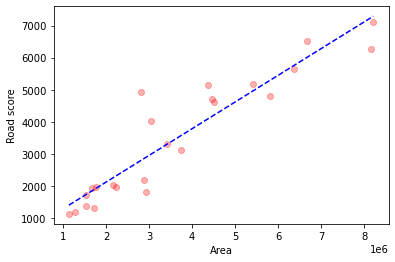

In [31]:
#Linear regression to see the correlation between the area and the road score
x = np.array(gdf.to_crs('epsg:2154').geometry.area)
y = np.array(gdf.road_score)
a,b,r,p,std_err = linregress(x,y)

plt.plot(x,y,'ro', alpha=0.3)
mi,ma = min(x), max(x)
plt.plot([mi, ma], [a*mi+b, a*ma+b], 'b--')
plt.xlabel('Area')
plt.ylabel('Road score')
print('a = ', a, ' b = ', b, ' r^2 = ', r**2)

In [32]:
#Total emissions from transport in 2019: 756 ktCO2eq

total_emissions_on_road = 756

gdf['CO2_from_road_transportation (kt CO2eq)'] = gdf['road_score']*total_emissions_on_road/gdf['road_score'].sum()
gdf['CO2_from_road_transportation_per_hab'] = gdf['CO2_from_road_transportation (kt CO2eq)']/gdf['hab']*1000

#Adding the airport
gdf['CO2_from_transportation (kt CO2 eq)'] = gdf.apply(lambda x: x['CO2_from_road_transportation (kt CO2eq)'] + 229 if x.freguesia == 'Olivais' else x['CO2_from_road_transportation (kt CO2eq)'], axis=1)
gdf['CO2_from_transportation_per_hab'] = gdf['CO2_from_transportation (kt CO2 eq)']/gdf['hab']*1000

In [33]:
#2019 5.11t eqC02 per capita: https://ourworldindata.org/grapher/consumption-co2-per-capita?tab=chart&country=~PRT
#Purchasing power index per capita is 205: https://www.pordata.pt/en/municipalities/purchasing+power+per+capita-118

CO2 = 5.11*205/100

In [36]:
#Adding the columns

gdf['Total consumption based t eqCO2'] = CO2*gdf['estate_weight']

In [37]:
#Total GHG emissions per freguesia
gdf['CO2_emissions_per_hab (tCO2eq)'] = gdf['CO2_from_energy_per_hab (tCO2eq)'] + gdf['CO2_from_transportation_per_hab'] + gdf['CO2_from_waste_per_hab']

In [38]:
#Adding freguesias' area
gdf['area'] = gdf.to_crs('epsg:2154').geometry.area

In [39]:
#Saving in Shapefile and GeoSJON
gdf.to_file('gdf.shp', encoding='utf-8')
gdf.to_file('gdf.geojson', driver='GeoJSON') 

In [40]:
from keplergl import KeplerGl

copy = gdf.copy(deep=True)

map_2 = KeplerGl(height=800, data={"data_1": copy})
map_2

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'data_1':                   freguesia    hab  zipcode  electricity (kWh)  \
0                  …

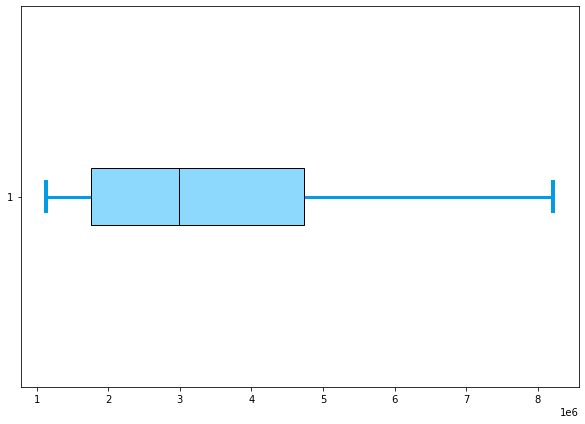

In [41]:
#Boxplots

fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)

# Creating axes instance
bp = ax.boxplot(gdf.to_crs('epsg:2154').geometry.area, patch_artist = True, vert = 0)

colors = ['#8DD8FD']

for patch, color in zip(bp['boxes'], colors):
	patch.set_facecolor(color)

# changing color and linewidth of
# whiskers
for whisker in bp['whiskers']:
	whisker.set(color ='#049BE6',
				linewidth = 3)
    
# changing color and linewidth of
# caps
for cap in bp['caps']:
	cap.set(color ='#049BE6',
			linewidth = 4)

# changing color and linewidth of
# medians
for median in bp['medians']:
	median.set(color ='black',
			linewidth = 1)

# changing style of fliers
for flier in bp['fliers']:
	flier.set(marker ='D',
			color ='#e7298a',
			alpha = 0.5)

	
# show plot
plt.show()
